<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#File-information" data-toc-modified-id="File-information-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>File information</a></span></li><li><span><a href="#Load-images-for-one-video" data-toc-modified-id="Load-images-for-one-video-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load images for one video</a></span></li><li><span><a href="#Load-all-images" data-toc-modified-id="Load-all-images-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load all images</a></span></li><li><span><a href="#Export-intensity-data" data-toc-modified-id="Export-intensity-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Export intensity data</a></span></li><li><span><a href="#Process-and-plot-kymograph" data-toc-modified-id="Process-and-plot-kymograph-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Process and plot kymograph</a></span></li><li><span><a href="#Obtain-velocity-from-kymograph" data-toc-modified-id="Obtain-velocity-from-kymograph-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Obtain velocity from kymograph</a></span></li></ul></div>

Plot live imaging intensity profiles (averaged) and kymographs

In [1]:
import numpy as np
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from pandas import DataFrame
from numpy import fft
import os
cwd = os.getcwd(); print("Working dir: " + cwd)


Working dir: /Users/dang/Documents/Projects/Tabler_skull/Scripts/Scripts_python


In [2]:
plt.rcParams["font.size"] = "16"

# For using LateX
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [3]:
# Save folder
#save_folder = '/Users/dang/Documents/Projects/Tabler_skull/Figures/Live_imaging_intensity_profiles/'
#save_folder = os.path.split(cwd)[0] + "/Figures/"; 
save_folder = '/Users/dang/Documents/Projects/Tabler_skull/Figures/temp/'
print("Save plots in: " + save_folder)

Save plots in: /Users/dang/Documents/Projects/Tabler_skull/Figures/temp/


### File information

In [13]:
## WT movies
load_folder = '/Users/dang/Documents/Projects/Tabler_skull/Data_Live_Imaging/Original datasets/'
folders_WT = [load_folder, load_folder, load_folder, load_folder]

fname_load_all = ["190305 Live Imaging/MaxProjected_Stitched_Blurred_190305_ML1_OsxGFP_Explant_Video_1(0-12hr).tif",
            "190314 Live Imaging/MaxProjected_Stitched_190314 ML1 OsxGFP Explant Video 1 (0-16hr).tif",
            "200120 Live Imaging/MaxProjected_Stitched_200120 Live Imaging OsxGFP E1375 12 hours.tif",
            "170902 Live Imaging/MAX_BLUR_20200414AQR_osx_E13.5_020917.lif - TileScan_003_Merging.tif"]

fnames_in_all_WT = [os.path.join( folders_WT[i], fname_load_all[i] ) for i in range(len(folders_WT))];

fname_ids = ["Video1_MaxProjected_Stitched_Blurred_190305_ML1_OsxGFP_Explant_Video_1_(0-12hr)",
                   "Video2_MaxProjected_Stitched_Blurred_190314 ML1 OsxGFP Explant (0-8hr)",
                   "Video3_MaxProjected_Stitched_Blurred_200120 Live Imaging OsxGFP E1375 12 hours",
                   "Video4_MAX_BLUR_20200414AQR_osx_E13.5_020917.lif - TileScan_003_Merging"]

# Video properties
# number of pixels per micron
pix_per_micron_all_WT = [4.400, 5.1040, 5.1040, 4.4034];

# total size of image in pixels
size_px_all_WT = np.array([[3782, 2882], [5612, 2850], [4734, 3925], [4643, 2886]]);
# size = np.array([859.55, 655]); # 190305
# size = np.array([1099.53, 562.5]); # 190314
# size = np.array([927.51, 769.01]); # 200120
# size = np.array([4643, 2886])/pix_per_micron; # 200120

# bounds for filtering interfaces
lower_all_WT = [50, 50, 700, 50]  
upper_all_WT = [-200, -200, -150, -150];

In [14]:
## BAPN movies
folders_BAPN = ["/Users/dang/Documents/Projects/Tabler_skull/Data_Live_Imaging/211223 BAPN E14.0 live imaging/",
                "/Users/dang/Documents/Projects/Tabler_skull/Data_Live_Imaging/221114 BAPN E14.0 live imaging/"]

# fname_load_all_BAPN = ["MaxProjected_Stitched_Blurred_dataset_cropped.tif",
#                  "MaxProjected_Stitched_1_TiffConverted_cropped.tif"]
fname_load_all_BAPN = ["MaxProjected_Stitched_dataset_cropped.tif",
                 "MaxProjected_Stitched_1_TiffConverted_cropped.tif"]

fnames_in_all_WT = [os.path.join( folders_BAPN[i], fname_load_all_BAPN[i] ) for i in range(len(folders_BAPN))];

fname_ids_BAPN = ["Video1_BAPN_E14.0_211223", "Video2_BAPN_E14.0_221114"]

#fname_in = fname_load_all[video_idx]

## Video properties
# Total image size in pixels
size_px_all_BAPN = np.array([[3732, 2720], [3716, 2632]]); # get new sizes

# Number of pixels per micron
pix_per_micron_all_BAPN = [3.368, 3.376]; # random value, get correct value

# bounds for filtering interfaces
lower_all_BAPN = [0, 0]  
upper_all_BAPN = [-1, -1];

### Load images for one video

In [21]:
##########
## Select video
video = 1;
video_idx = video-1; # python index

fname_id = fname_ids[video_idx]

WT = 0;
BAPN = 1;
if WT:
    load_folder = folders_WT[video_idx];
    fname_in = fname_load_all_BAPN[video_idx];
    size_px = size_px_all[video_idx];
    pix_per_micron = pix_per_micron_all[video_idx];
    lower = lower_all[video_idx];
    upper = upper_all[video_idx];
elif BAPN:
    load_folder = folders_BAPN[video_idx];
    fname_in = fname_load_all_BAPN[video_idx];
    size_px = size_px_all_BAPN[video_idx];
    pix_per_micron = pix_per_micron_all_BAPN[video_idx];
    lower = lower_all_BAPN[video_idx];
    upper = upper_all_BAPN[video_idx];

##########

In [22]:
os.path.join(load_folder, fname_in)

'/Users/dang/Documents/Projects/Tabler_skull/Data_Live_Imaging/211223 BAPN E14.0 live imaging/MaxProjected_Stitched_Blurred_dataset_cropped.tif'

In [23]:
# Load image
# from PIL import Image
# im = Image.open(load_folder + fname_in)
# im.show()
from skimage import io
image = io.imread( os.path.join(load_folder, fname_in) )
print(image.shape)

(85, 3708, 3732)


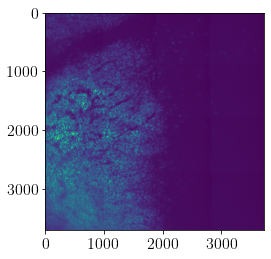

In [24]:
img = image[0];
img = img[lower:upper, :]
if video==2:
    img = np.fliplr(img)
    
plt.figure();
plt.imshow(img)

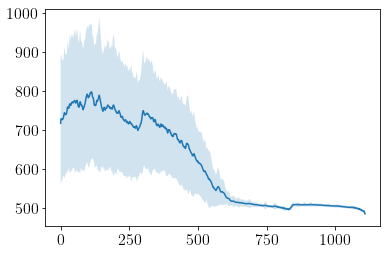

In [25]:
# Plot for single time point
img = image[0];
x_lb = 0 #50;
x_ub = -1 #-50;
if video==2:
    img = np.fliplr(img)
img = img[lower:upper, x_lb:x_ub]
intensity_avg = np.mean(img, axis=0)
intensity_std = np.std(img, axis=0)
x_data = np.arange( img.shape[1] )/pix_per_micron

plt.figure();
plt.plot(x_data, intensity_avg );
plt.fill_between(x_data, intensity_avg-intensity_std, intensity_avg+intensity_std, alpha=0.2)

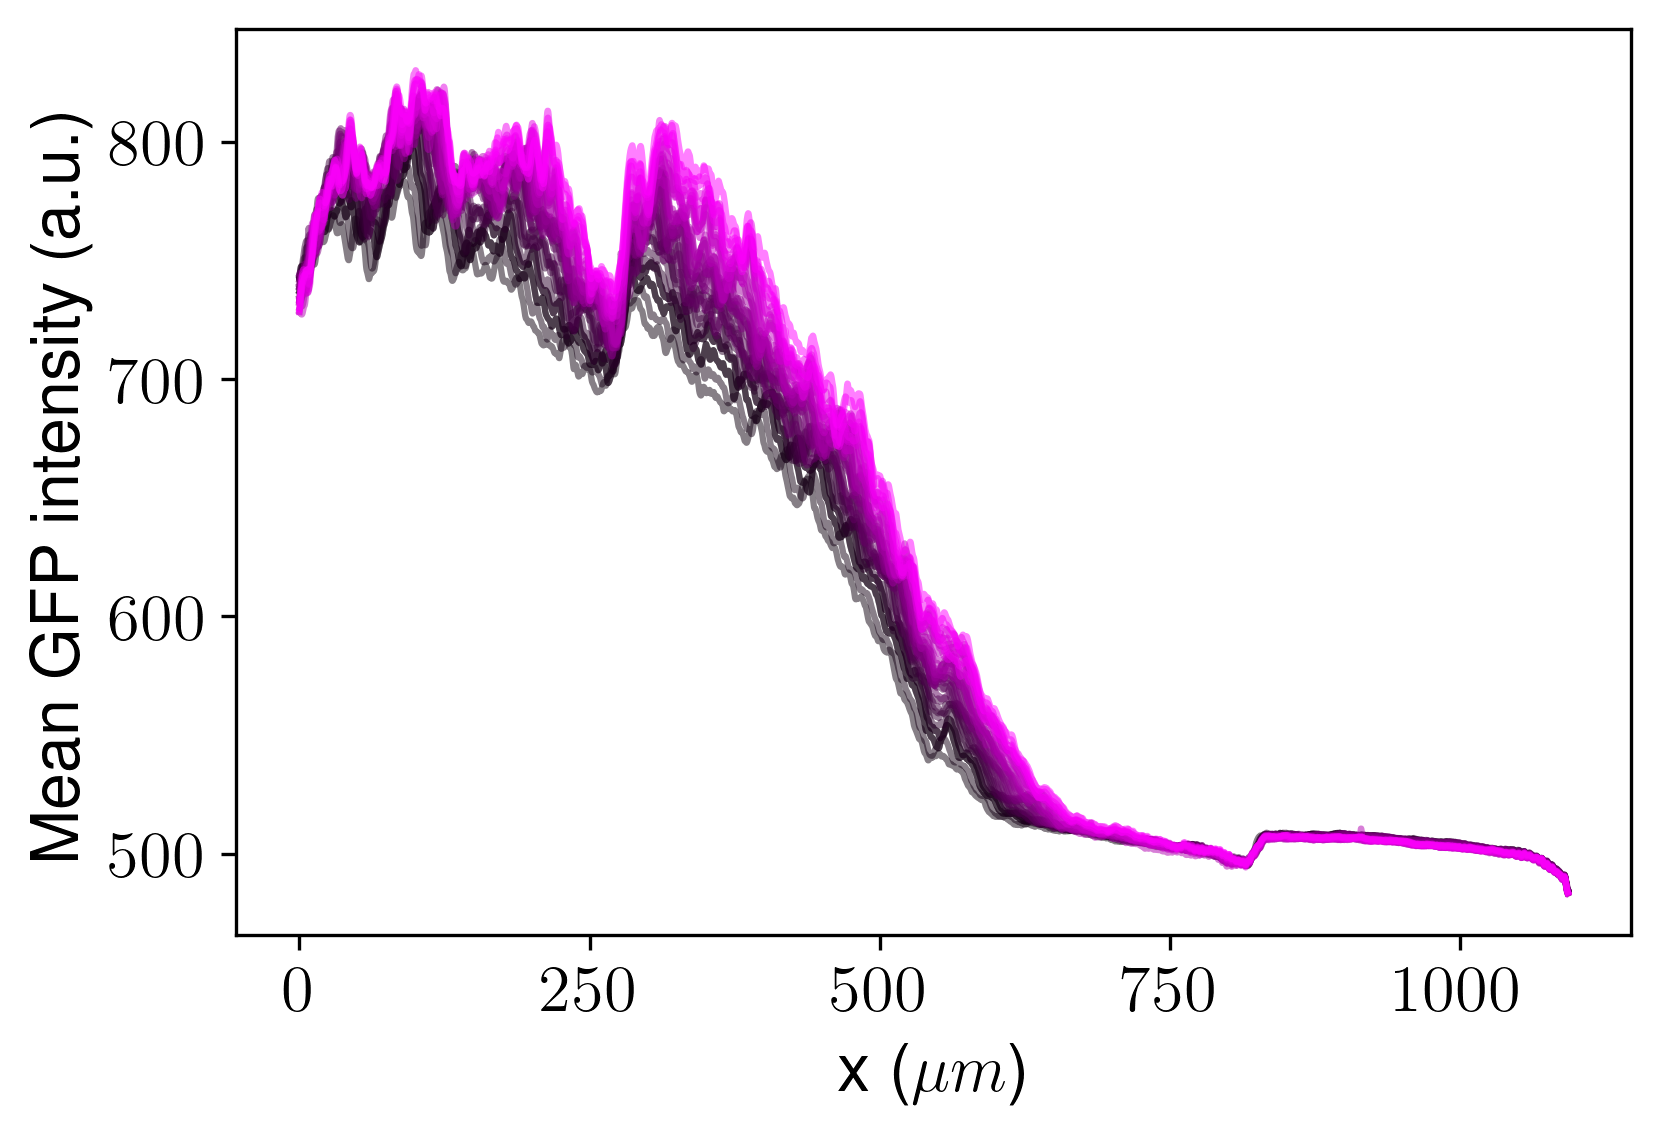

In [42]:
# also crop in x direction
x_lb = 50;
x_ub = -1;
t_selected = np.arange(0, 37)
#t_selected = np.arange(0, image.shape[0])

plt.figure( dpi=300); # figsize=(8, 6),
for i in range(len(t_selected)):
    ti = t_selected[i]
    
    img = image[ti][lower:upper, x_lb:x_ub]; # IMPORTANT: crop correctly
    if video==2:
        img = np.fliplr(img)
    intensity_avg = np.mean(img, axis=0)
    intensity_std = np.std(img, axis=0)
    x_data = np.arange( img.shape[1] )/pix_per_micron
    #plt.plot(x_data, intensity_avg, color=[0, i/image.shape[0], 0, 0.5] );
    plt.plot(x_data, intensity_avg, color=[ti/np.max(t_selected), 0, ti/np.max(t_selected), 0.5] );
    #plt.fill_between(x_data, intensity_avg-intensity_std, intensity_avg+intensity_std, alpha=0.2)
    
    plt.xlabel('x ($\mu m$)')
    plt.ylabel('Mean GFP intensity (a.u.)')
    
    #save_fname = fname_id + '_intensity_profiles_magenta_tmax_6hrs.pdf';
    #plt.savefig( os.path.join(save_folder, save_fname) )

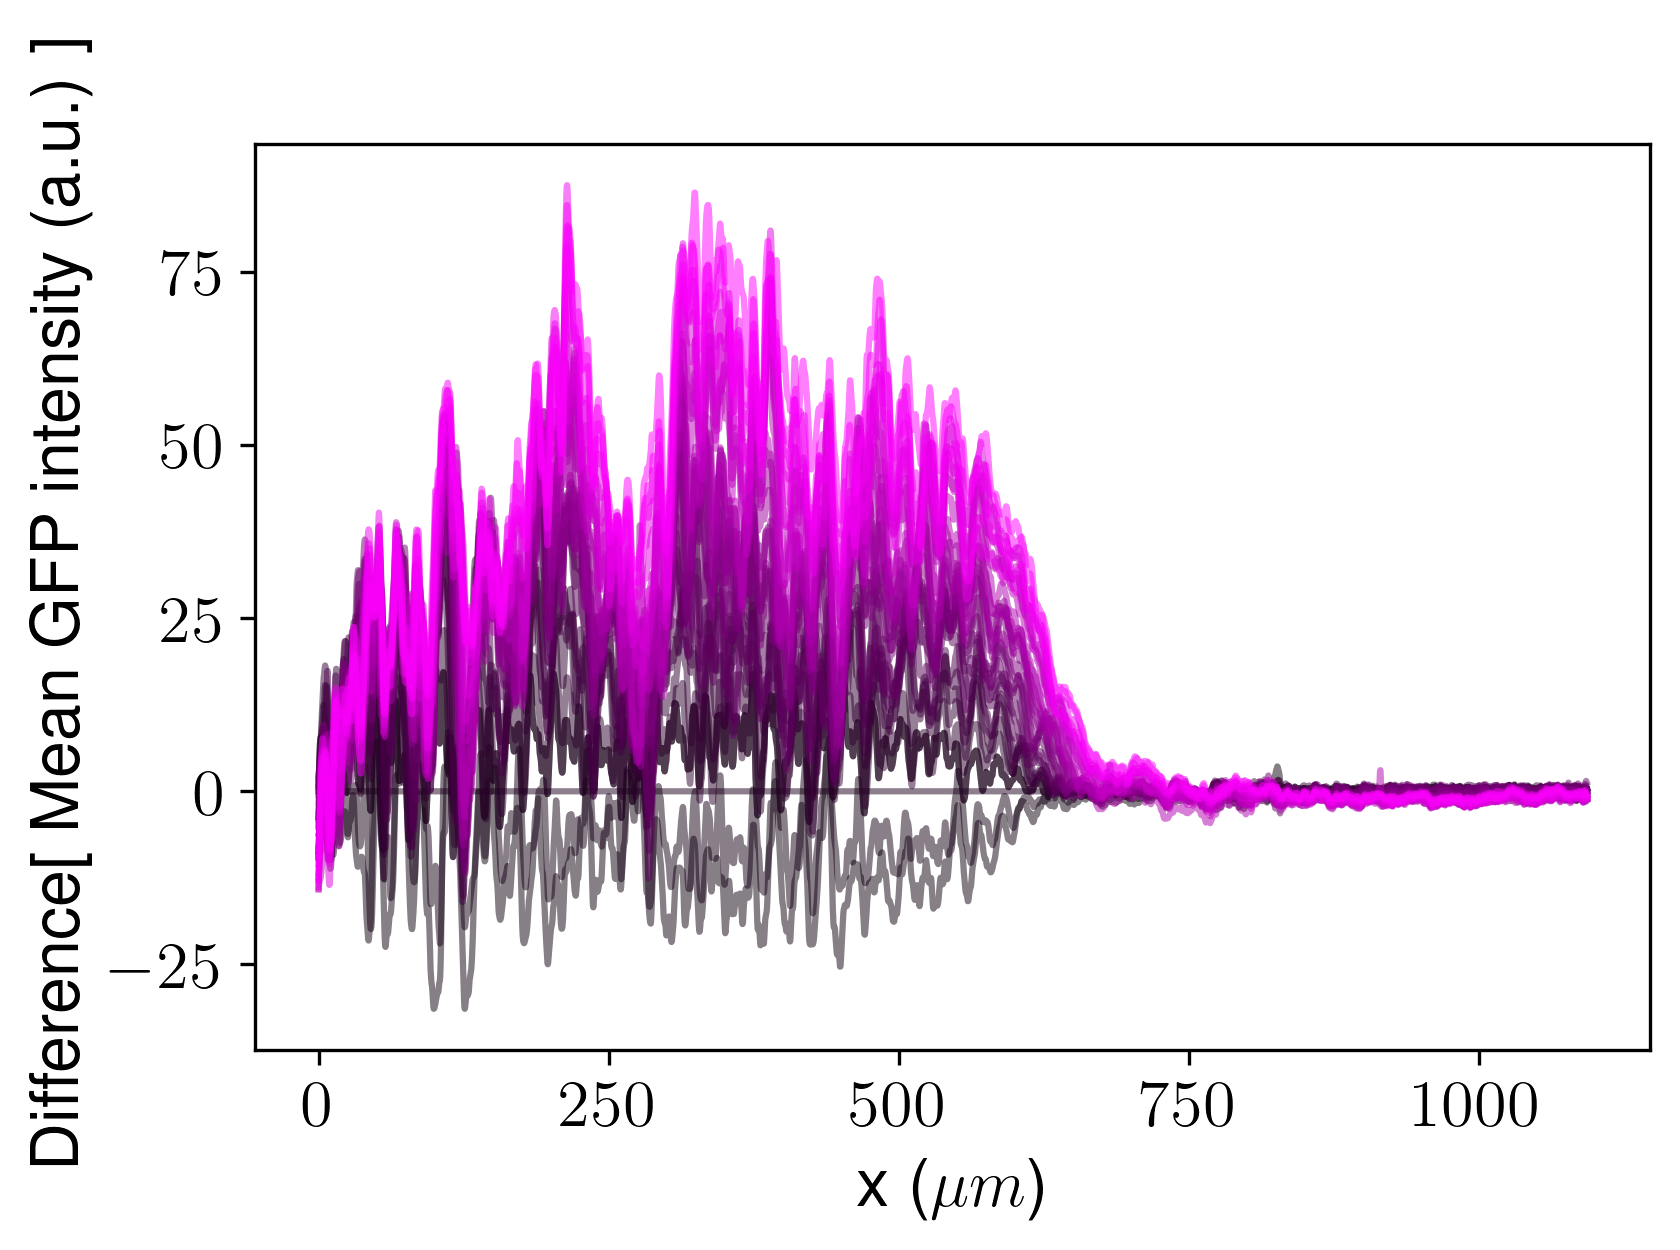

In [44]:
# Calculate change of intensity over time
img0 = image[0][lower:upper, x_lb:x_ub]
intensity_avg0 = np.mean(img0, axis=0)

# img0.shape[1]
d_intensities_all = np.zeros( (len(t_selected)-1, img0.shape[1] )) 

plt.figure( dpi=300); # figsize=(8, 6),
for i in range(1, len(t_selected)):
    ti = t_selected[i]
    img = image[ti][lower:upper, x_lb:x_ub]; # IMPORTANT: crop correctly
    d_intensities_all[i-1, :] = np.mean(img, axis=0)-intensity_avg0
    
    # plot result
    plt.plot(x_data, d_intensities_all[i-1, :], color=[ti/np.max(t_selected), 0, ti/np.max(t_selected), 0.5] );
    plt.xlabel('x ($\mu m$)')
    plt.ylabel('Difference[ Mean GFP intensity (a.u.) ]')
    

### Load all images

In [18]:
## 
########
WT = 1;
BAPN = 0;

if WT:
    fnames_in_all = fnames_in_all_WT
    pix_per_micron_all = pix_per_micron_all_WT
    size_px_all = size_px_all_WT
    lower_all = lower_all_WT
    upper_all = upper_all_WT
elif BAPN:
    fnames_in_all = fnames_in_all_BAPN
    pix_per_micron_all = pix_per_micron_all_BAPN
    size_px_all = size_px_all_WT
    lower_all = lower_all_BAPN
    upper_all = upper_all_BAPN
##########

In [20]:
# Load all images
from skimage import io
images = [];

for j in range(len(fnames_in_all)):
    image = io.imread(load_folder + fnames_in_all[j])
    image = image[:, lower_all[j]:upper_all[j], :]
    images.append(image)
    print(image.shape)

# flip images of video 2
for t_idx in range( images[1].shape[0] ):
    images[1][t_idx] = np.fliplr(images[1][t_idx]);

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dang/Documents/Projects/Tabler_skull/Data_Live_Imaging/Original datasets/Users/dang/Documents/Projects/Tabler_skull/Data_Live_Imaging/211223 BAPN E14.0 live imaging/MaxProjected_Stitched_dataset_cropped.tif'

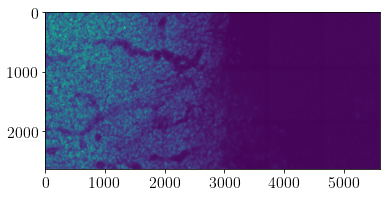

In [78]:
# Show an image
video = 2; 
video_idx=video-1;
plt.figure();
plt.imshow(images[1][0, :, :])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


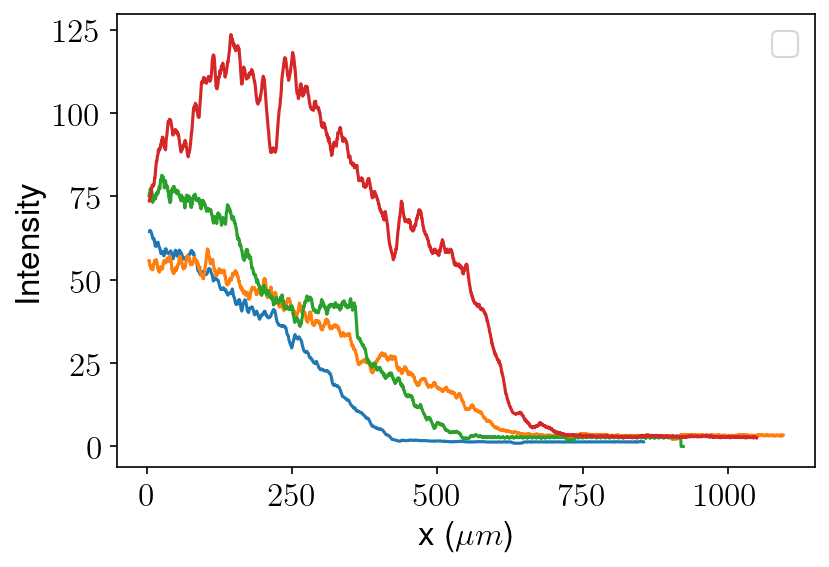

In [12]:
# Plot first time point in original reference frame
x_lb = 20; 
x_ub = -20; 

plot_data = []
for j in range(len(images)):
    plot_data.append( np.mean(images[j][0, :, :], axis=0) ) # scale data by resolution
# plot_data[1] = np.flip( plot_data[1] );

# rescale by magnification
plt.figure(dpi=150);
for j in range(len(images)):
    x_data = np.arange( images[j].shape[-1] )/pix_per_micron_all[j]
    #plt.plot(x_data, plot_data[j])
    plt.plot(x_data[x_lb:x_ub], plot_data[j][x_lb:x_ub] )
plt.legend()
plt.xlabel('x ($\mu m$)')
plt.ylabel('Intensity')
#     print(j)
#     plt.plot( np.mean(images[j][0, :, :], axis=0) );
save_fname = 'All_videos_t0_intensity_profiles_original_frame.pdf';
# plt.savefig( os.path.join(save_folder, save_fname) )
    
plt.show()

In [ ]:
# Define shifted frame in which interfaces are aligned
# find last point where intensity is above a set threshold
threshold = 5;

# rescale intensities w.r.t. value at a fixed point (after resetting x values)
x_intensity = -300;
#x_intensity_range = [50, 300]; # w.r.t. average value across range

plt.figure(dpi=150);
for j in range(len(images)):
    x_data = np.arange( images[j].shape[-1] )/pix_per_micron_all[j]
    x_origin = np.where(plot_data[j]>threshold)[0][-1]/pix_per_micron_all[j]
    x_plot = x_data[x_lb:x_ub] - x_origin
    y_plot = plot_data[j][x_lb:x_ub];
    
    # w.r.t. max intensity
    idx_rescale = np.argmax(y_plot)
    y_plot = y_plot/y_plot[idx_rescale];
    
    # w.r.t. single point
    #idx_rescale = np.where(x_plot>x_intensity)[0][0] # index of x value to rescale w.r.t. 
    #y_plot = y_plot/y_plot[idx_rescale];
    
    # w.r.t. region
    #idx_rescale = np.where((x_plot>x_intensity_range[0]) & (x_plot<x_intensity_range[1]))[0]
    #y_plot = y_plot/np.mean(y_plot[idx_rescale]);
    
    if j!=3:
        #plt.plot(x_data, plot_data[j])
        plt.plot(x_plot, y_plot )
    
plt.legend()
plt.xlabel('x ($\mu m$)')
plt.ylabel('Intensity')
save_fname = 'All_videos_t0_intensity_profiles_shifted_frame_scale_intensities_3_excl_video3.pdf';
# plt.savefig( os.path.join(save_folder, save_fname) )
    
plt.show()

### Export intensity data

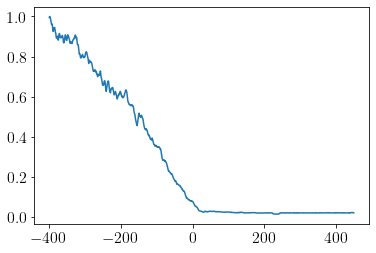

In [157]:
# Export intensity data
j=0; # video to export

x_data = np.arange( images[j].shape[-1] )/pix_per_micron_all[j]
x_origin = np.where(plot_data[j]>threshold)[0][-1]/pix_per_micron_all[j]
x_plot = x_data[x_lb:x_ub] - x_origin
y_plot = plot_data[j][x_lb:x_ub];

# w.r.t. single point
#idx_rescale = np.where(x_plot>x_intensity)[0][0] # index of x value to rescale w.r.t. 
idx_rescale = np.argmax(y_plot)
y_plot = y_plot/y_plot[idx_rescale];

plt.plot(x_plot, y_plot )
# 

Smoothen using triangular smoothing. Example from https://plotly.com/python/smoothing/.

In [158]:
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

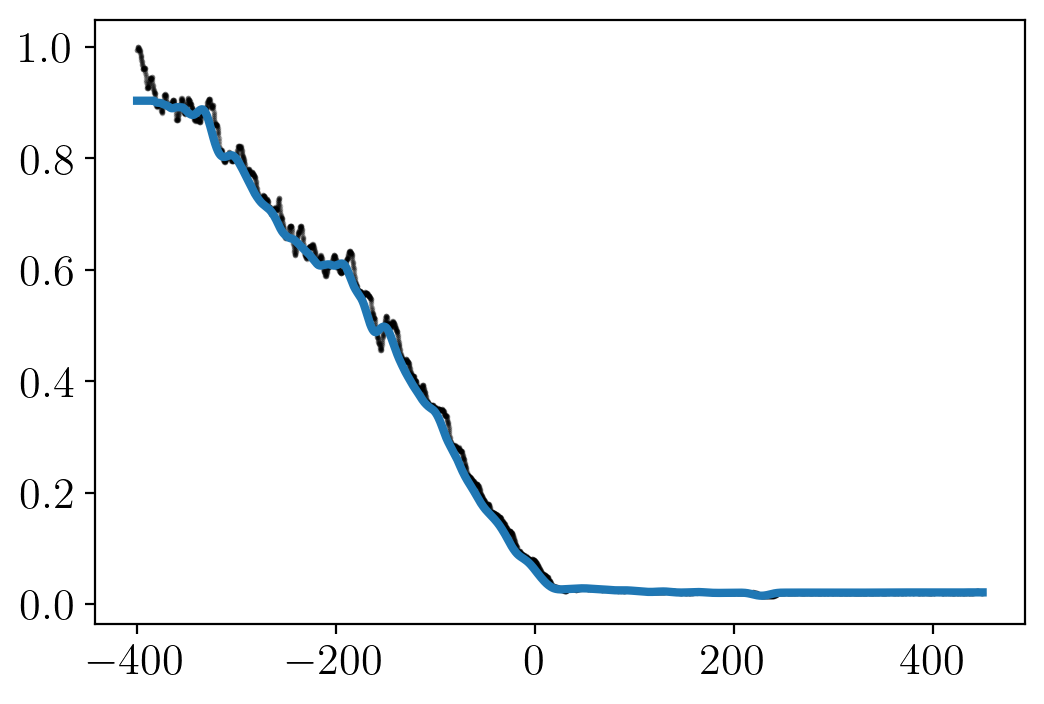

In [159]:
y_smooth = smoothTriangle(y_plot, 50)

plt.figure(dpi=200)
plt.scatter(x_plot, y_plot, 1, 'k', alpha=0.3 )
plt.plot(x_plot, y_smooth, linewidth=3 )
plt.show()

In [160]:
# Export data
import pandas as pd
data_out = pd.DataFrame( [x_plot, y_smooth], index=['x', 'y'] )

fname_out = '/Users/dang/Documents/Projects/Tabler_skull/Figures/Live_imaging_intensity_profiles/smoothened_profile_video_1_scaled_intensities.xlsx';
data_out.to_excel(fname_out)

### Process and plot kymograph

In [13]:
intensities_all = np.zeros([image.shape[0], image.shape[2]]);
for i in range(image.shape[0]):
    intensities_all[i, :] = np.mean(image[i], axis=0); 
    #intensities_all[i, :] = np.flip( np.mean(image[i], axis=0) ); 

/Users/dang/Documents/Projects/Tabler_skull/Figures/temp/Video_1_OsxGFP_kymograph_t_max_12


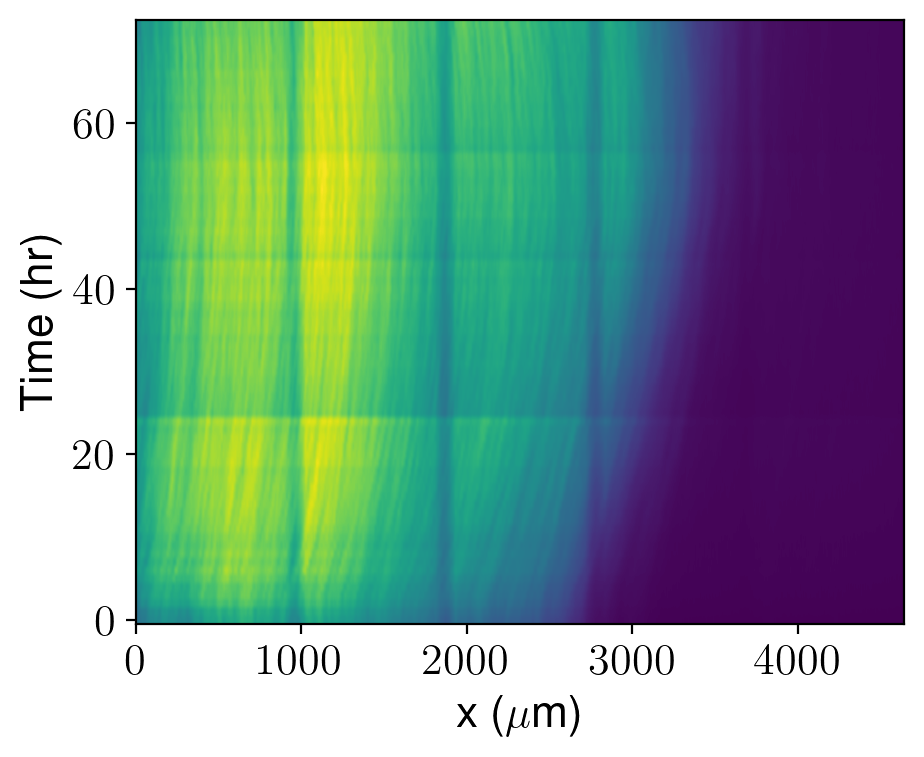

In [15]:
# tmax = image.shape[0]/6;
# t_all = np.arange(0, tmax, 1/6)
# x_all = np.linspace(0, size[1], image.shape[2]);
t_max_plot = 12;
idx_max = int(t_max_plot*6+1)

h=plt.figure(dpi=200);
plt.imshow(intensities_all[:idx_max,:], aspect=50, origin='lower') #, extent=[0, size[1], 0, t_max_plot])
plt.xlabel('x ($\mu$m)')
plt.ylabel('Time (hr)')

# save image
fname_out = save_folder + "Video_" +str(video) + "_OsxGFP_kymograph_t_max_"+str(t_max_plot);
ext = ".eps";
print(fname_out)
#plt.savefig(fname_out + ".eps")
#plt.savefig(fname_out + ".pdf")

plt.show()


### Obtain velocity from kymograph